In [1]:
import os
import pathlib
import shutil
from decimal import Decimal

from nautilus_trader.common.providers import InstrumentProvider
from nautilus_trader.model.bar import BarSpecification
from nautilus_trader.model.currencies import USD
from nautilus_trader.model.enums import BarAggregation
from nautilus_trader.model.enums import PriceType

from nautilus_trader.backtest.config import *
from nautilus_trader.backtest.config import BacktestConfig, BacktestVenueConfig, BacktestDataConfig
from nautilus_trader.backtest.data_loader import DataCatalog, DataLoader, CSVParser
from tests.test_kit.providers import TestInstrumentProvider
from tests.test_kit.strategies import EMACross
from tests.test_kit import PACKAGE_ROOT
from tests.test_kit.stubs import TestStubs

TEST_DATA_DIR = str(pathlib.Path(PACKAGE_ROOT).joinpath("data"))

### Firstly we need to load some data into the DataCatalog

In [2]:
# Set a path for the catalog
path = pathlib.Path.cwd() / "catalog"
if path.exists():
    shutil.rmtree(path.absolute())
path.mkdir(exist_ok=True)
os.environ.update({"NAUTILUS_BACKTEST_DIR": str(path)})

In [3]:
# Load one of the CSV test files into the DataCatalog
from functools import partial

def parse_csv_tick(df, instrument_id, state=None):
    from nautilus_trader.core.datetime import secs_to_nanos
    from nautilus_trader.model.objects import Price
    from nautilus_trader.model.objects import Quantity

    yield TestInstrumentProvider.default_fx_ccy("AUD/USD")
    for r in df.values:
        ts = secs_to_nanos(pd.Timestamp(r[0]).timestamp())
        tick = QuoteTick(
            instrument_id=instrument_id,
            bid=Price.from_str(str(r[1])),
            ask=Price.from_str(str(r[2])),
            bid_size=Quantity.from_int(1_000_000),
            ask_size=Quantity.from_int(1_000_000),
            ts_event_ns=ts,
            ts_recv_ns=ts,
        )
        yield tick

instrument_provider = InstrumentProvider()
instrument_provider.add(TestInstrumentProvider.default_fx_ccy("AUD/USD"))
loader = DataLoader(
    path=TEST_DATA_DIR,
    parser=CSVParser(
        parser=partial(parse_csv_tick, instrument_id=TestStubs.audusd_id())
    ),
    glob_pattern="truefx-audusd-ticks.csv",
    instrument_provider=instrument_provider,
)

catalog = DataCatalog()
catalog.import_from_data_loader(loader=loader, progress=True)
assert len(catalog.instruments()) == 1
assert len(catalog.quote_ticks()) == 100000

100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


### Use the new `BacktestConfig` object to incrementally build up a backtest configuration

The `BacktestConfig` object takes similar configuration to the engine; `venues`, `instruments`, `data` and `strategies`. 

The benefit though, is that it can be partially configured (instantiated partially and/or with `update` method) and duplicated with ease (via the `replace` method which returns a copy).

In [4]:
# Create a `base` config object to be shared with all backtests
base = BacktestConfig(
    venues=[
        BacktestVenueConfig(
            name="SIM",
            venue_type="ECN",
            oms_type="HEDGING",
            account_type="MARGIN",
            base_currency=USD,
            starting_balances=[Money(1_000_000, USD)],
        )
    ]
)
base

Partial-BacktestConfig(venues=[BacktestVenueConfig(name='SIM', venue_type='ECN', oms_type='HEDGING', account_type='MARGIN', base_currency=Currency(code=USD, name=United States dollar, precision=2, iso4217=840, type=FIAT), starting_balances=[Money('1000000.00', USD)], fill_model=None, modules=None)], instruments=None, data_config=None, strategies=None, name=None)

**Notice the `Partial-` prefix, indicating the object is not fully configured.**

We can confirm this by using the `check` method, which confirms we have required config remaining

In [5]:
base.check()

AssertionError: Missing fields: ['instruments', 'data_config', 'strategies', 'name']

#### We can continue to configure the backtest via `update`

The `data_config` arg allows adding multiple data types (quotes, trades, generic_data), but for one specific backtest run

In [6]:
# Add some specific data and instruments
instrument = TestInstrumentProvider.default_fx_ccy("AUD/USD", venue=Venue("SIM"))

data_config=[
    BacktestDataConfig(
        data_type=QuoteTick,
        instrument_id=instrument.id.value,
        start_time=1580398089820000000,
        end_time=1580504394501000000,
    )
]

config = base.update(
    instruments=[instrument],
    data_config=data_config,
)

config

Partial-BacktestConfig(venues=[BacktestVenueConfig(name='SIM', venue_type='ECN', oms_type='HEDGING', account_type='MARGIN', base_currency=Currency(code=USD, name=United States dollar, precision=2, iso4217=840, type=FIAT), starting_balances=[Money('1000000.00', USD)], fill_model=None, modules=None)], instruments=[CurrencySpot(id=AUD/USD.SIM, symbol=AUD/USD, asset_class=FX, asset_type=SPOT, quote_currency=USD, is_inverse=False, price_precision=5, price_increment=0.00001, size_precision=0, size_increment=1, multiplier=1, lot_size=1000, margin_init=0.03, margin_maint=0.03, maker_fee=0.00002, taker_fee=0.00002, info=None)], data_config=[BacktestDataConfig(data_type=<class 'nautilus_trader.model.tick.QuoteTick'>, instrument_id='AUD/USD.SIM', start_time=1580398089820000000, end_time=1580504394501000000, filters=None)], strategies=None, name=None)

### Finally, we can perform a grid-search of some parameters by using the `replace` method, which returns a new copy of the config

Note here the `strategy` is actually a tuple of (`TradingStrategy` class, `kwargs` dict), as we can't (currently) serialize a trading strategy to send to dask workers.

In [7]:
PARAM_SET = [
    {"fast_ema": 10, "slow_ema": 20},
    {"fast_ema": 20, "slow_ema": 30},
    {"fast_ema": 30, "slow_ema": 40},
]

configs = []
for params in PARAM_SET:
    strategy = (
        EMACross,
        dict(
            instrument_id=instrument.id,
            bar_spec=BarSpecification(15, BarAggregation.MINUTE, PriceType.BID),
            trade_size=Decimal(1_000_000),
            **params
        ),
    )
    # Create the final config
    new = config.replace(strategies=[strategy])
    
    configs.append(new)

You can also optionally assign a `name` to the config, otherwise an unique hash will be generated

### This creates 3 sets of parameters to run over

In [8]:
configs

[Partial-BacktestConfig(venues=[BacktestVenueConfig(name='SIM', venue_type='ECN', oms_type='HEDGING', account_type='MARGIN', base_currency=Currency(code=USD, name=United States dollar, precision=2, iso4217=840, type=FIAT), starting_balances=[Money('1000000.00', USD)], fill_model=None, modules=None)], instruments=[CurrencySpot(id=AUD/USD.SIM, symbol=AUD/USD, asset_class=FX, asset_type=SPOT, quote_currency=USD, is_inverse=False, price_precision=5, price_increment=0.00001, size_precision=0, size_increment=1, multiplier=1, lot_size=1000, margin_init=0.03, margin_maint=0.03, maker_fee=0.00002, taker_fee=0.00002, info=None)], data_config=[BacktestDataConfig(data_type=<class 'nautilus_trader.model.tick.QuoteTick'>, instrument_id='AUD/USD.SIM', start_time=1580398089820000000, end_time=1580504394501000000, filters=None)], strategies=[(<class 'tests.test_kit.strategies.EMACross'>, {'instrument_id': InstrumentId('AUD/USD.SIM'), 'bar_spec': BarSpecification(15-MINUTE-BID), 'trade_size': Decimal('1

### The `build_graph` function turns one or more configs into a dask task graph (delayed object).

In [9]:
task = build_graph(configs)
task

Delayed('gather-b3fb00a0-70c2-486e-9e57-9f5a5eb85196')

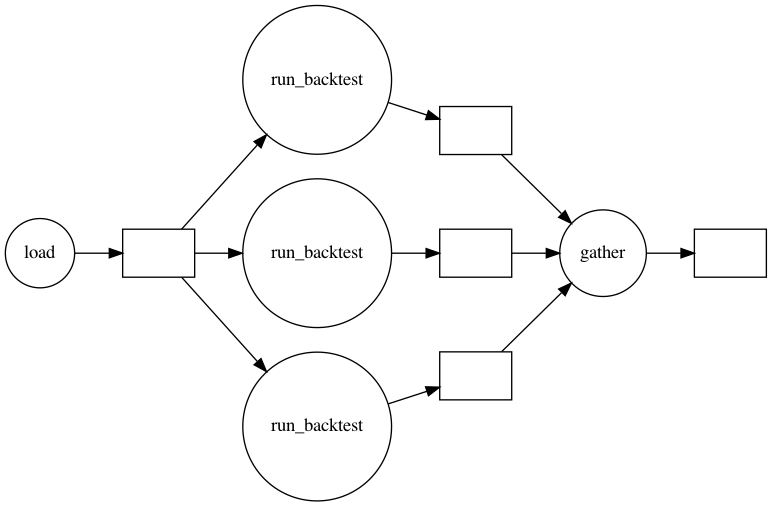

In [10]:
task.visualize(rankdir='LR')

#### Notice because our configs share the same data that only one instance of `load` is required

### Start up a local dask cluster to execute the graph

In [11]:
# Create a local dask client
from distributed import Client
client = Client(n_workers=2)
client

/Users/bradleymcelroy/Library/Caches/pypoetry/virtualenvs/nautilus-trader-9CWMrM3f-py3.9/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60191 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:60191/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:60191/status,Workers: 2
Total threads: 8,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:60192,Workers: 2
Dashboard: http://127.0.0.1:60191/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:60196,Total threads: 4
Dashboard: http://127.0.0.1:60198/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:60195,


### Run the backtests!

In [12]:
results = task.compute()

In [31]:
results

{'backtest-f6db99029a46bc85f9a43c84069aca95': {'account':                                  balance_USD venue
  timestamp                                         
  2020-01-30 20:15:00.275000+00:00   999986.58   SIM
  2020-01-31 00:15:01.969000+00:00   999893.16   SIM
  2020-01-31 00:15:01.969000+00:00   999879.74   SIM
  2020-01-31 01:00:00.016000+00:00   998806.30   SIM
  2020-01-31 01:00:00.016000+00:00   998792.86   SIM
  2020-01-31 03:15:00.104000+00:00   997959.43   SIM
  2020-01-31 03:15:00.104000+00:00   997946.00   SIM
  2020-01-31 05:00:01.939000+00:00   997022.56   SIM
  2020-01-31 05:00:01.939000+00:00   997009.12   SIM
  2020-01-31 07:00:00.116000+00:00   996275.69   SIM
  2020-01-31 07:00:00.116000+00:00   996262.26   SIM
  2020-01-31 13:45:00.288000+00:00   997638.86   SIM
  2020-01-31 13:45:00.288000+00:00   997625.46   SIM
  2020-01-31 15:30:00.972000+00:00   996948.68   SIM
  2020-01-31 15:30:00.972000+00:00   996962.07   SIM
  2020-01-31 20:59:54.501000+00:00   997035